## Load data ##

In [431]:
import pickle
import pandas as pd
import numpy as np

def loadNbaData():
    with open('NBA_Data_Cleaned_df.pickle', 'rb') as file:
        nba_df = pickle.load(file)

    with open('teamID_mappings.pickle', 'rb') as file:
        team_mappings = pickle.load(file)
        teamID_newID_dict = team_mappings['teamID_newID_dict']
        
    nba_df[['team_id_home', 'team_id_away']] = nba_df[['team_id_home', 'team_id_away']].replace(teamID_newID_dict)

    X_df = nba_df.drop(columns=['season_id', 'new_season_id', 'wl_home', 'game_date', 'wl_away', 'fg_pct_home']) #, 'team_id_home', 'team_id_away', 'season_type'])
    y_df = nba_df[['wl_home']].reset_index(drop=True)

    # X_df.insert(10, 'rest_days_home', X_df.pop('rest_days_home'))
    # X_df.insert(21, 'rest_days_away', X_df.pop('rest_days_away'))

    # print(X_df.dtypes)
    # print(y_df.dtypes)

    X = X_df.to_numpy()
    y = y_df.to_numpy()

    return X,y

X,y = loadNbaData()

print("X shape: ", X.shape)
print("y shape: ", y.shape)

# print("Home team: ", (X[:,0:10]).shape)
# print("Away team: ", (X[:,11:21]).shape)
# print("Season type: ", (X[:,22:]).shape)

X shape:  (44549, 23)
y shape:  (44549, 1)


In [432]:
import torch 

X_torch = torch.from_numpy(X).type(torch.float32)
y_torch = torch.from_numpy(y).type(torch.float32).round()


In [433]:
from torch.utils.data import Dataset, DataLoader

class NBADataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

In [434]:
from torch.utils.data import random_split

dataset = NBADataset(X_torch, y_torch)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 2048

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Create FFN module ##

In [ ]:
import torch.nn as nn

# class FFN(nn.Module):
#     def __init__(self, input_size):
#         super(FFN, self).__init__()
#         self.fc_home = nn.Linear(input_size//2)
#         self.fc_away = nn.Linear(input_size//2)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size*2 + 1)
#         self.fc3 = nn.Linear(hidden_size, 1)
#         self.sigmoid = nn.Sigmoid()



#     def forward(self, x):
#         x_home = self.fc_home(x[:,0:11])
#         x_away = self.fc_away(x[:,11:22])

#         x = torch.cat((x_home, x_away, x[:,22:]), dim=1)
#         x = self.relu(self.fc2(x))
#         x = self.sigmoid(self.fc3(x))
#         return x

class FFN(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()




    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output(x)
        return x
        



In [436]:
# Function to train and test model 

def AccuracyAndLossOverEpoch(model, train_loader, test_loader, optimizer, criterion, device, epochs = 20):
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    model.to(device)

    for epoch in range(epochs):
        # Set current epoch train loss, train accuracy and test accuracy to 0.0
        train_loss = 0.0
        train_acc = 0.0
        test_acc = 0.0

        # Put model in training mode
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            # Get loss on current batch
            loss = criterion(y_pred, y_batch)
            loss.backward()
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            # print(f"Epoch {epoch+1}, Gradient Norm: {total_norm}")
            optimizer.step()
            # Accumulate train loss in epoch
            train_loss += loss.item()
        # Add train loss to train_losses, in order to track
        # print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")
        train_losses.append(train_loss)

        # Put model in evaluation mode
        model.eval()
        correct = 0.0
        total = 0.0
        with torch.no_grad():
            # Iterate over train dataset, in order to get accuracy for model at current epoch
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(X_batch)
                y_pred = nn.Sigmoid()(y_pred)
                y_pred = (y_pred >= 0.5).float().round()
                correct += (y_pred == y_batch).sum().item()
                total += len(y_batch)
        # Add train accuracy to train_accuracies
        train_acc = correct / total
        # print(f"Epoch {epoch+1}, Training Accuracy: {train_acc}")
        train_accuracies.append(train_acc)

        # Put model in evaluation mode
        model.eval()
        correct = 0.0
        total = 0.0
        with torch.no_grad():
            # Iterate over test dataset, in order to get accuracy for model at current epoch
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(X_batch)
                y_pred = nn.Sigmoid()(y_pred)
                y_pred = (y_pred >= 0.5).float()
                # print(y_pred)
                # print(y_batch)
                correct += (y_pred == y_batch).sum().item()
                total += len(y_batch)
        # Add test accuracy to test_accuracies
        test_acc = correct / total
        print(f"Epoch {epoch+1}, Test Accuracy: {test_acc}")
        test_accuracies.append(test_acc)

    return train_losses, train_accuracies, test_accuracies

In [ ]:
# initialize model, optimizer and loss function

model = FFN(input_size=X.shape[1], hidden_size=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# Train and test model 

train_losses, train_accuracies, test_accuracies = AccuracyAndLossOverEpoch(model, train_loader, test_loader, optimizer, criterion, device, epochs = 100)

Epoch 1, Test Accuracy: 0.4115600448933782
Epoch 2, Test Accuracy: 0.4152637485970819
Epoch 3, Test Accuracy: 0.4287317620650954
Epoch 4, Test Accuracy: 0.44399551066217735
Epoch 5, Test Accuracy: 0.45634118967452303
Epoch 6, Test Accuracy: 0.4708193041526375
Epoch 7, Test Accuracy: 0.4858585858585859
Epoch 8, Test Accuracy: 0.5015712682379349
Epoch 9, Test Accuracy: 0.5141414141414141
Epoch 10, Test Accuracy: 0.5254769921436588
Epoch 11, Test Accuracy: 0.5317620650953985
Epoch 12, Test Accuracy: 0.5393939393939394
Epoch 13, Test Accuracy: 0.5435465768799103
Epoch 14, Test Accuracy: 0.5493827160493827
Epoch 15, Test Accuracy: 0.551290684624018
Epoch 16, Test Accuracy: 0.555331088664422
Epoch 17, Test Accuracy: 0.5597081930415264
Epoch 18, Test Accuracy: 0.5636363636363636
Epoch 19, Test Accuracy: 0.5674523007856341
Epoch 20, Test Accuracy: 0.5704826038159372
Epoch 21, Test Accuracy: 0.574635241301908
Epoch 22, Test Accuracy: 0.5782267115600449
Epoch 23, Test Accuracy: 0.581144781144781

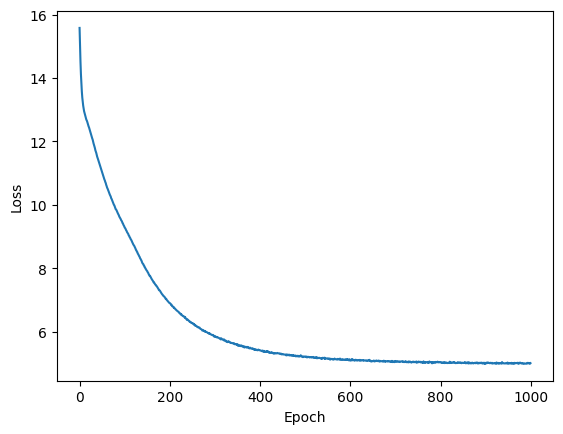

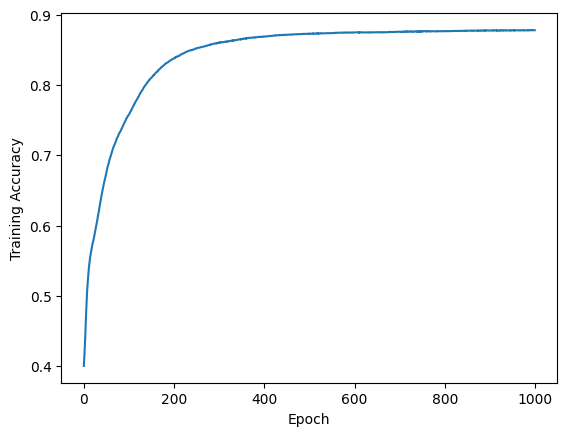

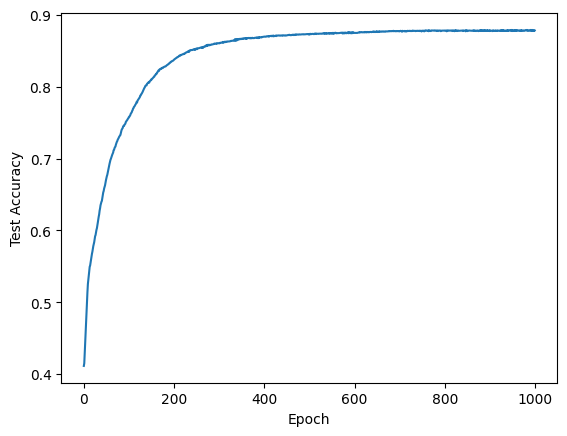

In [441]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(train_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(test_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.show()

In [439]:
def search_for_best_model(optimizer_name, learning_rates, model, train_loader, test_loader, criterion, device, epochs = 100):
    
    best_test_accuracy = 0.0
    best_learning_rate = 0.0
    best_model = None

    for learning_rate in learning_rates:
        if optimizer_name == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_name == "RMSprop":
            optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
        elif optimizer_name == "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        train_losses, train_accuracies, test_accuracies = AccuracyAndLossOverEpoch(model, train_loader, test_loader, optimizer, criterion, device, epochs = epochs)
        if test_accuracies[-1] > best_test_accuracy:
            best_test_accuracy = test_accuracies[-1]
            best_learning_rate = learning_rate
            best_model = model

    return best_learning_rate, best_model

In [440]:
# best_learning_rate, best_model = search_for_best_model("Adam", [0.00001, 0.0001, 0.001, 0.01], model, train_loader, test_loader, criterion, device)